<h1> DV Trusted Context Example</h1>

<p><strong>Welcome!</strong> This notebook shows an example of how to configure and use Trusted Context in the Data Virtualization database.  After some initial set up cells, the first part of of the notebook is the configuraiton section that would need to be run once (Configure Trusted Context), and the second part shows how to use it and switch users from the one that made the connection (Example of Using Trusted Context). </p>

Please note that I use both Db2 Magic Commands as well as lower level Python commands to query Db2.  The I use the lower level commands in places where I need to change connection properties for trusted context.

<p><strong>TAKE NOTE</strong> This notebook or any code in it should not used for any production purposes.  It is meant only to provide examples of how you might want to use trusted context.   </p>

## Set up Db2 environment and connection credentials

Get the Db2 notebook to configure the environment, run it and then configure the Database credentials 

In [1]:
import wget
url = 'https://raw.githubusercontent.com/IBM/db2-jupyter/master/db2.ipynb'
filename = wget.download(url)
filename

'db2 (6).ipynb'

In [2]:
#filename = 'db2 (2).ipynb'
#print(filename)
%run "$filename"

Db2 Extensions Loaded.


My user, 1030, has been granted administrator privilidges because these are needed to create the trusted context object, create roles and grant privilidges to those roles.

In [3]:
user1030_id = 'user1030'
user1030_pw = 'yourPassw0rd'

In this case I am using the 1008 DV user id of Emily the Business Analyst as the service account or generic user_id that stands in for a generic user id that an application server would use to connect to DV.  It turns out that you can't create a trusted context for your own user id.  

In [4]:
user1008_id = 'user1008'
user1008_pw = 'yourOtherPassword'

# Configure Trusted Context

Connect to the data base with the DV admin ID using the Db2 Magic commands privided by executing the above db2 notebook.  

In [ ]:
%sql CONNECT TO bigsql USER {user1030_id} USING {user1030_pw} HOST dv-server.cp4d.svc.cluster.local PORT 32051

##### Note the python CLIENT_IPADDR from the list of connections

Query the connections to the DV server to note the IP address (CLIENT_IPADDR) needed to create the Trusted Context later.  Generally this will be the IP Address of your applicaiton server, but in this case it is the IP of the server running your notebook.  Sometimes the address APPLICATION_ID will be diffrent from the one in CLIENT_IPADDR.  Make sure to use the CLIENT_APADDR value!   The important lines are highlighted in this example.  From it you can see that the interesting IP address is 10.129.3.183 and that IP is used in the CREATE TRUSTED CONTEXT command later. Make sure to run this query from a client on the application server to verify which IP Address the DV server thinks the queries are coming from.  

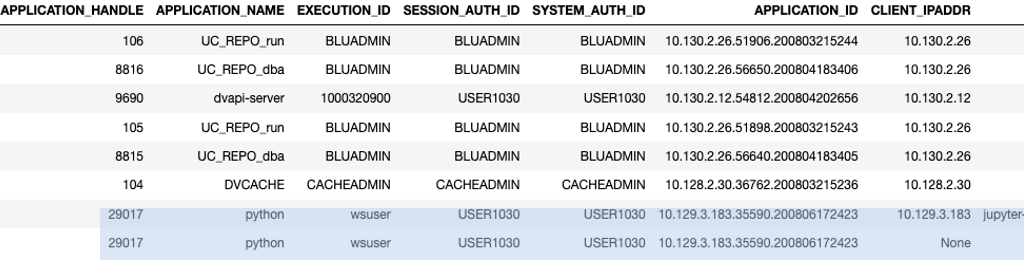

In [ ]:
%%sql
SELECT application_handle, 
       application_name,
       EXECUTION_ID,
       SESSION_AUTH_ID,
       SYSTEM_AUTH_ID,       
       application_id, 
       CLIENT_IPADDR,
       CLIENT_WRKSTNNAME  
FROM TABLE(MON_GET_CONNECTION(cast(NULL as bigint), -2)) AS t 
ORDER BY rows_returned DESC;

### Create the role called "app_server_role" to provide privilidges to users

Any user using the database through the trusted context will be granted this role.  In our examples we will query the stock virtual table.  Note that the role needs connect authority, because we will switch to user id's that don't actually exist in DV.  In this way of using trusted context, the only reason for switching is to beable to see who the end user is and not to have the users actually defined to DV.  This means that those users would never be able to acctually connect to DV unless they know the service id, its password and log in from one of the IP's defined in the trusted context.  Finally, I grant execute on the MON_GET_CONNECTION procedure to make it convenient for me to show the user in DV.  

In [ ]:
%sql drop role app_server_role;

In [ ]:
%sql create role app_server_role;

In [ ]:
%sql grant connect on database to role app_server_role;
%sql grant select on user1030.stock to role app_server_role;
%sql grant execute on function sysproc.MON_GET_CONNECTION to role app_server_role;

### Create the Trusted Context

Since a user/service account connecting to DV using trusted context is allowed to switch to another user, this feature is limited to a list IP addresses or host names. Use the IP address you noted from the connections query above.  You really only need that IP, but I show using multiple IPs just to show a more robust example.  

In [ ]:
%sql drop trusted context ctx1;

In [ ]:
%%sql
create trusted context ctx1
       based upon connection using system authid user1008
       attributes (address '172.18.43.241',
                   address '192.168.0.5',
                   address '10.129.3.183')
       default role app_server_role
       with use for PUBLIC without authentication
       enable

It is always a good practice to disconnect when you are done with your DV connection.

In [ ]:
%sql connect reset

# Example of using Trusted Context

Use Db2 functions to configure trusted context parameters that will be used later as well as the string to query the stock table

In [5]:
options = {ibm_db.SQL_ATTR_USE_TRUSTED_CONTEXT: ibm_db.SQL_TRUE}
tc_brad = {ibm_db.SQL_ATTR_USE_TRUSTED_CONTEXT: ibm_db.SQL_TRUE, ibm_db.SQL_ATTR_TRUSTED_CONTEXT_USERID: "brad" }
tc_bob = {ibm_db.SQL_ATTR_USE_TRUSTED_CONTEXT: ibm_db.SQL_TRUE, ibm_db.SQL_ATTR_TRUSTED_CONTEXT_USERID: "bob" }
query="select count(*) from user1030.stock"
print(options)
print(tc_brad)
print(tc_bob)
print(query)

{2561: 1}
{2561: 1, 2562: 'brad'}
{2561: 1, 2562: 'bob'}
select count(*) from user1030.stock


Connect to the DV database using the user1008 service account.

In [6]:
connect_string = "DATABASE=BIGSQL;HOSTNAME=dv-server.cp4d.svc.cluster.local;" + \
                 "PORT=32051;" + "PROTOCOL=TCPIP;UID=" + user1008_id + ";PWD=" + user1008_pw;
print(connect_string)
conn = ibm_db.connect(connect_string, "", "",options)

DATABASE=BIGSQL;HOSTNAME=dv-server.cp4d.svc.cluster.local;PORT=32051;PROTOCOL=TCPIP;UID=user1008;PWD=zTJ3I0e8@#z%X2*l


Run a query as user1008. If the query fails, run the connection in the cell above again.  Usually the second connection does the trick, but sometimes more are needed.

In [7]:
stmt=ibm_db.exec_immediate(conn, query)
result = ibm_db.fetch_both(stmt)
print ("Number of stock rows selected by service account = "+ str(result[0]))

Number of stock rows selected by service account = 500000


Now look at the connections and notice that one of the python connections is made through the user1008 service account.  The other two python connections are the magic command connections used for this query.

In [8]:
%sql CONNECT TO bigsql USER {user1030_id} USING {user1030_pw} HOST dv-server.cp4d.svc.cluster.local PORT 32051
%sql SELECT application_handle, application_name,EXECUTION_ID, SESSION_AUTH_ID, \
       SYSTEM_AUTH_ID, application_id, CLIENT_IPADDR, CLIENT_WRKSTNNAME \
         FROM TABLE(sysproc.MON_GET_CONNECTION(cast(NULL as bigint), -2)) AS t  \
        ORDER BY rows_returned DESC;

Connection successful.


,APPLICATION_HANDLE,APPLICATION_NAME,EXECUTION_ID,SESSION_AUTH_ID,SYSTEM_AUTH_ID,APPLICATION_ID,CLIENT_IPADDR,CLIENT_WRKSTNNAME
0,106,UC_REPO_run,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.51906.200803215244,10.130.2.26,10.130.2.26
1,8816,UC_REPO_dba,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.56650.200804183406,10.130.2.26,10.130.2.26
2,9690,dvapi-server,1000320900,USER1030,USER1030,10.130.2.12.54812.200804202656,10.130.2.12,dv-api-576b867b9f-2rgzq
3,29184,python,wsuser,USER1008,USER1008,10.129.3.183.59210.200806174803,10.129.3.183,jupyter-py36-27767bb8-fa93-4698-b3a5-9cabdb264...
4,105,UC_REPO_run,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.51898.200803215243,10.130.2.26,None
5,8815,UC_REPO_dba,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.56640.200804183405,10.130.2.26,None
6,104,DVCACHE,CACHEADMIN,CACHEADMIN,CACHEADMIN,10.128.2.30.36762.200803215236,10.128.2.30,10.128.2.30
7,29187,python,wsuser,USER1030,USER1030,10.129.3.183.59722.200806174812,10.129.3.183,jupyter-py36-27767bb8-fa93-4698-b3a5-9cabdb264...
8,29187,python,wsuser,USER1030,USER1030,10.129.3.183.59722.200806174812,None,None


In [9]:
%sql connect reset

Connection closed.


##### Switch user to brad after commit.  User will not switch if there is any uncommitted work.

In [10]:
ibm_db.exec_immediate(conn, "commit")
stmt=ibm_db.set_option(conn, tc_brad, 1)

Run a query as brad

In [11]:
stmt=ibm_db.exec_immediate(conn, query)
result = ibm_db.fetch_both(stmt)
print ("Number of stock rows selected by db2dean = "+ str(result[0]))

Number of stock rows selected by db2dean = 500000


Check the connections and verify that the Session and System authorization ids are "BRAD".  It is interesting that the Execution_ID is is the CPD log in associated with the DV user who established the connection.    

In [12]:
%sql CONNECT TO bigsql USER {user1030_id} USING {user1030_pw} HOST dv-server.cp4d.svc.cluster.local PORT 32051
%sql SELECT application_handle, application_name,EXECUTION_ID, SESSION_AUTH_ID, \
       SYSTEM_AUTH_ID, application_id, CLIENT_IPADDR, CLIENT_WRKSTNNAME \
         FROM TABLE(sysproc.MON_GET_CONNECTION(cast(NULL as bigint), -2)) AS t  \
        ORDER BY rows_returned DESC;

Connection successful.


,APPLICATION_HANDLE,APPLICATION_NAME,EXECUTION_ID,SESSION_AUTH_ID,SYSTEM_AUTH_ID,APPLICATION_ID,CLIENT_IPADDR,CLIENT_WRKSTNNAME
0,106,UC_REPO_run,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.51906.200803215244,10.130.2.26,10.130.2.26
1,8816,UC_REPO_dba,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.56650.200804183406,10.130.2.26,10.130.2.26
2,29184,python,wsuser,BRAD,BRAD,10.129.3.183.59210.200806174803,10.129.3.183,jupyter-py36-27767bb8-fa93-4698-b3a5-9cabdb264...
3,9690,dvapi-server,1000320900,USER1030,USER1030,10.130.2.12.54812.200804202656,10.130.2.12,dv-api-576b867b9f-2rgzq
4,105,UC_REPO_run,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.51898.200803215243,10.130.2.26,None
5,8815,UC_REPO_dba,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.56640.200804183405,10.130.2.26,None
6,104,DVCACHE,CACHEADMIN,CACHEADMIN,CACHEADMIN,10.128.2.30.36762.200803215236,10.128.2.30,10.128.2.30
7,29193,python,wsuser,USER1030,USER1030,10.129.3.183.34432.200806174905,10.129.3.183,jupyter-py36-27767bb8-fa93-4698-b3a5-9cabdb264...
8,29193,python,wsuser,USER1030,USER1030,10.129.3.183.34432.200806174905,None,None


In [ ]:
%sql connect reset

##### Switch the connection to bob, run a query and verify that the connection was running as bob.  

In [13]:
ibm_db.exec_immediate(conn, "commit")
stmt=ibm_db.set_option(conn, tc_bob, 1)

In [14]:
stmt=ibm_db.exec_immediate(conn, query)
result = ibm_db.fetch_both(stmt)
print ("Number of stock rows selected by db2dean = "+ str(result[0]))

Number of stock rows selected by db2dean = 500000


In [15]:
%sql CONNECT TO bigsql USER {user1030_id} USING {user1030_pw} HOST dv-server.cp4d.svc.cluster.local PORT 32051
%sql SELECT application_handle, application_name,EXECUTION_ID, SESSION_AUTH_ID, \
       SYSTEM_AUTH_ID, application_id, CLIENT_IPADDR, CLIENT_WRKSTNNAME \
         FROM TABLE(sysproc.MON_GET_CONNECTION(cast(NULL as bigint), -2)) AS t  \
        ORDER BY rows_returned DESC;

Connection successful.


,APPLICATION_HANDLE,APPLICATION_NAME,EXECUTION_ID,SESSION_AUTH_ID,SYSTEM_AUTH_ID,APPLICATION_ID,CLIENT_IPADDR,CLIENT_WRKSTNNAME
0,106,UC_REPO_run,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.51906.200803215244,10.130.2.26,10.130.2.26
1,8816,UC_REPO_dba,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.56650.200804183406,10.130.2.26,10.130.2.26
2,29184,python,wsuser,BOB,BOB,10.129.3.183.59210.200806174803,10.129.3.183,jupyter-py36-27767bb8-fa93-4698-b3a5-9cabdb264...
3,9690,dvapi-server,1000320900,USER1030,USER1030,10.130.2.12.54812.200804202656,10.130.2.12,dv-api-576b867b9f-2rgzq
4,105,UC_REPO_run,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.51898.200803215243,10.130.2.26,None
5,8815,UC_REPO_dba,BLUADMIN,BLUADMIN,BLUADMIN,10.130.2.26.56640.200804183405,10.130.2.26,None
6,104,DVCACHE,CACHEADMIN,CACHEADMIN,CACHEADMIN,10.128.2.30.36762.200803215236,10.128.2.30,10.128.2.30
7,29196,python,wsuser,USER1030,USER1030,10.129.3.183.35970.200806174933,10.129.3.183,jupyter-py36-27767bb8-fa93-4698-b3a5-9cabdb264...
8,29196,python,wsuser,USER1030,USER1030,10.129.3.183.35970.200806174933,None,None


In [16]:
%sql connect reset

Connection closed.


In [17]:
ibm_db.close(conn)

True